# 计算机视觉的迁移学习

参考：[cs231n](https://cs231n.github.io/transfer-learning/) & [transfer_learning_tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#further-learning)

- 微调卷积神经网络：不是使用随机初始化，而是使用预训练的网络初始化网络，例如在 ImageNet 1000 数据集上训练的网络。其余的训练过程与平常一样。
- 卷积神经网络作为固定特征提取器：在此，将冻结网络中所有层的权重，除了最后的全连接层。这个最后的全连接层被替换为具有随机权重的新的全连接层，并且只训练这一层。

In [1]:
from dataclasses import dataclass
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision.transforms import v2 
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from tempfile import TemporaryDirectory
from torch.profiler import profile, record_function, ProfilerActivity
logging.basicConfig(level=logging.INFO)
torch.cuda.empty_cache() # 清空 GPU 缓存
cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from pathlib import Path

temp_dir = Path(".").resolve() / ".temp"
temp_dir.mkdir(exist_ok=True)

In [3]:
@dataclass
class CIFAR10:
    root_dir: str

    def __post_init__(self):
        self.root_dir = Path(self.root_dir)
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.train_transform = v2.Compose([ # 在高度和宽度上将图像放大到40像素的正方形
            v2.Resize(40),
            # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
            # 生成一个面积为原始图像面积0.64到1倍的小正方形，
            # 然后将其缩放为高度和宽度均为32像素的正方形
            v2.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
            v2.RandomHorizontalFlip(),
            v2.ToImage(),
        ])
        self.val_transform = v2.ToImage()
        self.train = datasets.CIFAR10(
            root=self.root_dir, 
            train=True, download=True, 
            transform=self.train_transform,
        )
        self.val = datasets.CIFAR10(
            root=self.root_dir, 
            train=False, download=True,
            transform=self.val_transform,
        )
        self.normalize = nn.Sequential(
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(self.mean, self.std)
        )


In [4]:
dataset = CIFAR10(temp_dir/"data")
batch_size = 32
dataloaders = {
    "train": DataLoader(dataset.train, batch_size=batch_size, shuffle=True),
    "val": DataLoader(dataset.val, batch_size=batch_size, shuffle=False),
}
dataset_sizes = {
    "train": len(dataset.train),
    "val": len(dataset.val),
}
class_names = dataset.train.classes
# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 可视化输入

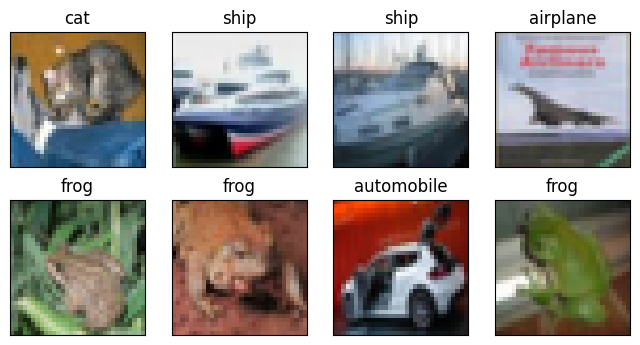

In [5]:
from taolib.plot.image import show_images
classe_names = dataset.train.classes
idx_to_class = {v:k for k, v in dataset.train.class_to_idx.items()}
# Get a batch of training data
inputs, classes = next(iter(dataloaders["val"]))
inputs, classes = inputs[:8], classes[:8]
inputs = [v2.ToPILImage()(inp) for inp in inputs]
# inputs = inputs.numpy().transpose((0, 2, 3, 1))
show_images(inputs, 2, 4, scale=2, titles=[idx_to_class[x.item()] for x in classes]);

## 训练模型

In [6]:
from torchvision.ops.misc import Conv2dNormActivation

class Model(nn.Module):
    def __init__(self, transform: nn.Module, *args, **kwargs):
        super().__init__(*args, **kwargs)
        model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        model.features[0] = Conv2dNormActivation(3, 32, stride=1, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU6)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
        self.model = model
        self.transform = transform

    def forward(self, x):
        x = self.transform(x)
        return self.model(x)


lr = 0.00142857
lr_decay = 0.00857142
weight_decay = 0.00857142
momentum = 0.857142
criterion = nn.CrossEntropyLoss()
model_ft = Model(dataset.normalize)
optimizer_ft = optim.SGD(
    model_ft.parameters(), lr=lr, momentum=momentum, 
    weight_decay=weight_decay
)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=lr_decay)

训练和评估模型：

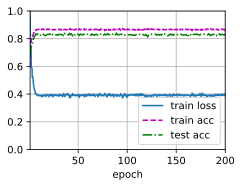

In [ ]:
from taolib.utils.timer import Timer
from torch_book.vision.classifier import Classifier
timer = Timer()
classifier = Classifier(
    model_ft, criterion, optimizer_ft, 
    exp_lr_scheduler, 
    dataloaders["train"], 
    dataloaders["val"], 
    device, 
    timer)
classifier.fit(200, checkpoint_dir=temp_dir/'checkpoint')

INFO:torch_book.vision.classifier:Saved checkpoint to /media/pc/data/lxw/ai/torch-book/doc/concepts/transfer-learning/.temp/checkpoint/epoch_400.pth
INFO:torch_book.vision.classifier:loss 0.35827, train acc 0.87896, test acc 0.8201
INFO:torch_book.vision.classifier:856.55 examples/sec on cuda:1


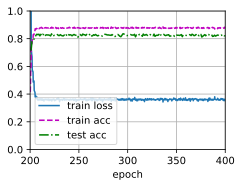

In [ ]:
from taolib.utils.timer import Timer
from torch_book.vision.classifier import Classifier
timer = Timer()
classifier = Classifier(
    model_ft, criterion, optimizer_ft, 
    exp_lr_scheduler, 
    dataloaders["train"], 
    dataloaders["val"], 
    device, 
    timer)
classifier.fit(200, checkpoint_dir=temp_dir/'checkpoint', resume_from=temp_dir/'checkpoint/best_model_params.pth', start_epoch=200)

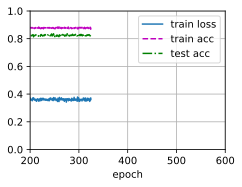

In [ ]:
from taolib.utils.timer import Timer
from torch_book.vision.classifier import Classifier
timer = Timer()
classifier = Classifier(
    model_ft, criterion, optimizer_ft, 
    exp_lr_scheduler, 
    dataloaders["train"], 
    dataloaders["val"], 
    device, 
    timer)
classifier.fit(400, checkpoint_dir=temp_dir/'checkpoint', resume_from=temp_dir/'checkpoint/best_model_params.pth', start_epoch=400)